In [ ]:
# взяла датасет с птицами- https://www.kaggle.com/datasets/hnganhlnguyn/bird-dataset/code


# **Задание:** Выберите любой датасет с картинками с kaggle (можно собрать свой!) и обучите на нем свертку-классификатор.

In [ ]:
!pip install torchvision torchmetrics # torchmetrics, чтобы руками не считать точность

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 16.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from torchmetrics import Accuracy as VAccuracy
from tqdm import tqdm
import random
import pandas as pd
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from matplotlib import cm # определенный набор цветов
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
import json
import os
token = {"username":"ksyushasemina","key":"ce4280ac01c4fa1f5dd6bac35cda82de"}
with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d hnganhlnguyn/bird-dataset -p /content
!unzip /content/bird-dataset.zip -d /content
!pwd
!ls /content

- path is now set to: /content
Dataset URL: https://www.kaggle.com/datasets/hnganhlnguyn/bird-dataset
License(s): unknown
 98% 145M/148M [00:02<00:00, 79.5MB/s]
100% 148M/148M [00:02<00:00, 68.3MB/s]
Archive:  /content/bird-dataset.zip
  inflating: /content/Bird_DataClassification/Test/0/macaw_1782.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1785.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1786.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1787.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1788.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1789.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1790.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1791.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1796.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1798.jpg  
  inflating: /content/Bird_DataClassification/Test/0/macaw_1799.

In [ ]:
# сделала это, так как в дальнейшем мне нужно все равно в csv перевести
train_directory = '/content/Bird_DataClassification/Train'
valid_directory = '/content/Bird_DataClassification/Valid'
test_directory = '/content/Bird_DataClassification/Test'

In [ ]:
# я попробую посчитать количества файлов в определенных директориях, работаю с изображениями, есть прекрасная библиотека glob, которая мне поможет
import glob
print('Train: parrot - ',len(glob.glob(train_directory+'/0/*')),' || oriole - ',len(glob.glob(train_directory+'/1/*')))
print('Validation: parrot - ',len(glob.glob(valid_directory+'/0/*')),' || oriole - ',len(glob.glob(valid_directory+'/1/*')))
print('Test: parrot - ',len(glob.glob(test_directory+'/0/*')),' || oriole - ',len(glob.glob(test_directory+'/1/*')))

Train: parrot -  1196  || oriole -  814
Validation: parrot -  403  || oriole -  200
Test: parrot -  564  || oriole -  175


1. Обучающая выборка:

   • Попугаи: 1196 изображений

   • Иволги: 814 изображений

Получается, что обучающая выборка содержит больше изображений попугаев, чем иволг. Это может привести к несбалансированности данных, а следовательно, может повлиять на обучение модели. Модель может лучше распознавать попугаев, так как она видит их чаще.

2. Валидационная выборка:

   • Попугаи: 403 изображения

   • Иволги: 200 изображений

Тогда получается, что алидационная выборка также несбалансирована, с большим количеством попугаев по сравнению с иволгами.

3. Тестовая выборка:

   • Попугаи: 564 изображения

   • Иволги: 175 изображений

Тестовая выборка также показывает значительное преобладание попугаев. Опять же возможно, модель будет лучше распознавать попугаев

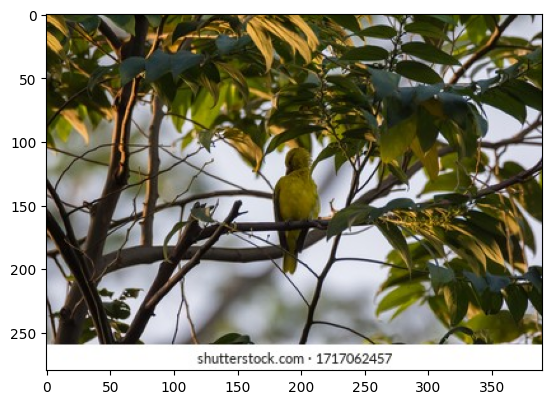

In [ ]:
# смотрела, кто тут есть
img = Image.open('/content/Bird_DataClassification/Valid/1/chim_vang_anh_629.jpg')
plt.imshow(img)
plt.show()

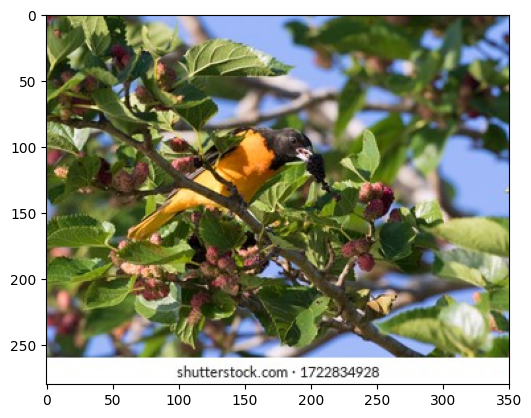

In [ ]:
img = Image.open('/content/Bird_DataClassification/Valid/1/chim_vang_anh_681.jpg')
plt.imshow(img)
plt.show()

In [ ]:
# попытка перевести датасет в csv файл
def create_csv_from_dataset(base_dir, output_csv_path):
    data = []
    for label_dir in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label_dir)
        if not os.path.isdir(label_path):
            continue

        for image_file in os.listdir(label_path):
            if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            image_path = os.path.join(label_path, image_file)
            data.append({'image_path': image_path, 'label': label_dir})

    df = pd.DataFrame(data)
    df.to_csv(output_csv_path, index=False)

In [ ]:
create_csv_from_dataset(train_directory, 'train_data.csv')
create_csv_from_dataset(valid_directory, 'valid_data.csv')
create_csv_from_dataset(test_directory, 'test_data.csv')

In [ ]:
# перевела датасет в scv
train_df = pd.read_csv('train_data.csv')
valid_df = pd.read_csv('valid_data.csv')
test_df = pd.read_csv('test_data.csv')

In [ ]:
train_df.sample(5) # посмотрю, что тут есть

,image_path,label
1064,/content/Bird_DataClassification/Train/0/macaw...,0
738,/content/Bird_DataClassification/Train/0/macaw...,0
649,/content/Bird_DataClassification/Train/0/macaw...,0
1520,/content/Bird_DataClassification/Train/1/chim_...,1
1525,/content/Bird_DataClassification/Train/1/chim_...,1


In [ ]:
valid_df.sample(5)

,image_path,label
34,/content/Bird_DataClassification/Valid/0/macaw...,0
511,/content/Bird_DataClassification/Valid/1/chim_...,1
353,/content/Bird_DataClassification/Valid/0/macaw...,0
227,/content/Bird_DataClassification/Valid/0/macaw...,0
107,/content/Bird_DataClassification/Valid/0/macaw...,0


In [ ]:
test_df.sample(5)

,image_path,label
144,/content/Bird_DataClassification/Test/0/macaw_...,0
13,/content/Bird_DataClassification/Test/0/macaw_...,0
728,/content/Bird_DataClassification/Test/1/chim_v...,1
187,/content/Bird_DataClassification/Test/0/macaw_...,0
603,/content/Bird_DataClassification/Test/1/chim_v...,1


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Функция для визуализации данных, для проверки распределения, хотя на самом деле через библиотеку glob было понятно, что данные несбалансированные
def plot_label_distribution(csv_path, title):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
    plt.title(title)
    plt.xlabel("Number of images")
    plt.ylabel("Bird Label")
    plt.show()

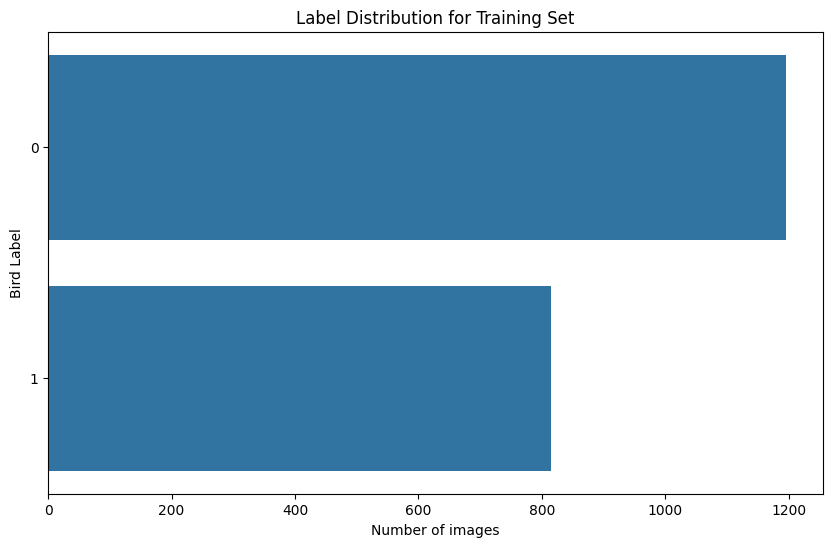

In [ ]:
plot_label_distribution('train_data.csv', "Label Distribution for Training Set")

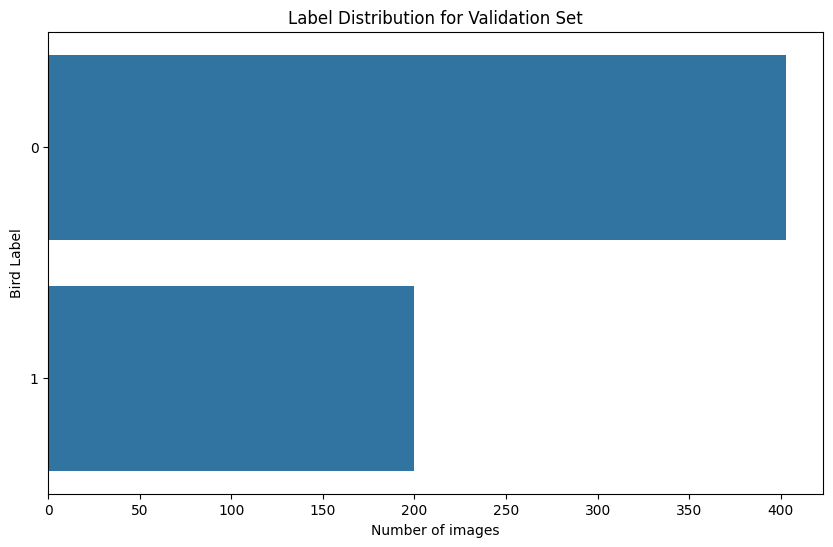

In [ ]:
plot_label_distribution('valid_data.csv', "Label Distribution for Validation Set")

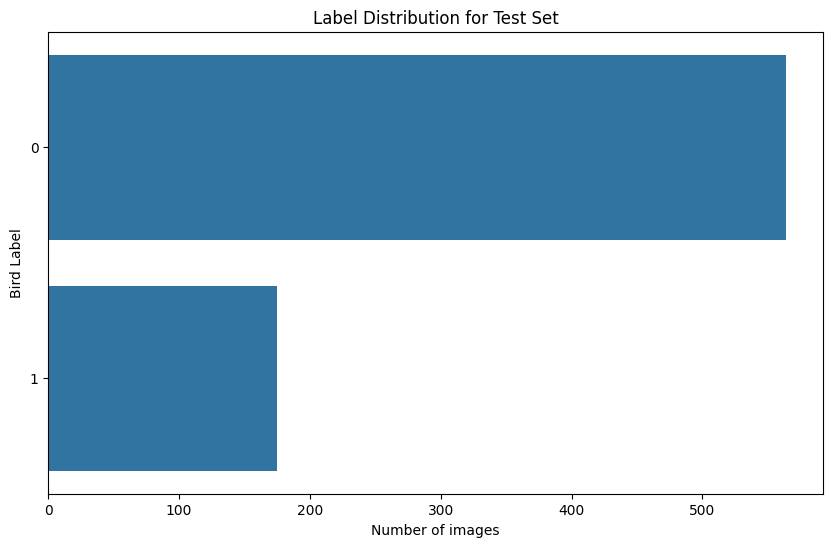

In [ ]:
plot_label_distribution('test_data.csv', "Label Distribution for Test Set")

Ну да, данные несбалансированы, получается, что количество картинок с попугаями превышает иволг.
Для того, чтобы это исправить можно попробовать применить аугментацию.

In [ ]:
train_df.info()
# смотрела типы данных
valid_df.info()

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2010 non-null   object
 1   label       2010 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  603 non-null    object
 1   label       603 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  739 non-null    object
 1   label       739 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.7+ KB



# **Попытка №1**

In [ ]:
# Напишу кастомный класс, но учту, что у меня несбалансированные данные и сильный перекос в сторону попугаев
class BirdDataset2(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']
        image = Image.open(image_path).convert('RGB')

        # пытаюсь применить аугментацию только к классу иволги (класс 1)
        if label == 1:
            if self.transform:
                image = self.transform(image)
        else:
            # для класса 0 просто применяем базовую трансформацию
            image = transforms.Resize((image_size, image_size))(image)
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label

In [ ]:
# Аугментация
image_size = 128 # установлю размер изображения 128
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),               # случайное горизонтальное отражение
    transforms.RandomRotation(10),                   # случайный поворот на 10 градусов
    transforms.Resize((image_size, image_size)),    # изменение размера на 128
    transforms.ToTensor(),                           # преобразование в тензор и нормализация в диапазон [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # нормализация по каналам, взяла значения по дефолту
])

In [ ]:
train_dataset = BirdDataset2(df=train_df, transform=transform) #применила аугментацию
valid_dataset = BirdDataset2(df=valid_df, transform=transform)
test_dataset = BirdDataset2(df=test_df, transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class ConvNetMNIST2(nn.Module):
    def __init__(self):
        super().__init__()

        # Сверточные слои
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=15, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)  # полинг уменьшает размеры в 2 раза

        self.conv_2 = nn.Conv2d(in_channels=5, out_channels=20, kernel_size=9, padding='same')

        # входное изображение имеет размер 128 на 128
        # после conv_1 (15 ядро) с padding='same' - выход 128 на 128
        # после поллинга - выход 64 на 64
        # после conv_2 (9 ядро) с padding='same' - выход 64 на 64
        # после пулинга - выход 32 на 32

        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(20 * 32 * 32, 128)
        self.fc_2 = nn.Linear(128, 2)

    def forward(self, x):
        pred = self.conv_1(x)
        pred = self.relu(pred)
        pred = self.pool(pred)

        pred = self.conv_2(pred)
        pred = self.relu(pred)
        pred = self.pool(pred)

        pred = self.flatten(pred)
        pred = self.fc_1(pred)
        pred = self.relu(pred)
        pred = self.fc_2(pred)

        return pred

In [ ]:
# посчитаю вес исходя из того, что есть в лейблах
from collections import Counter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = ConvNetMNIST2().to(device) # переместила на cuda
optimizer = optim.Adam(model2.parameters(), lr=0.005, betas=(0.9, 0.999), eps=1e-08)
# метки из обучающего датасета
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
total_count = sum(class_counts.values())
# Расчет весов классов и перемещение их на устройство
class_weights = torch.tensor([total_count / count for count in class_counts.values()]).float().to(device) # вычисляет веса для каждого класса и переносит их в устройство
# по этой формуле веса назначаются таким образом, чтобы более частые классы имели меньший вес, а менее частые классы - более высокий
# сколько образцов каждого класса присутствует в вашем обучающем наборе данных
# добавлю вес классов в функцию потерь
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
from tqdm.notebook import tqdm
num_epochs = 20
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    running_corrects = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
    for inputs, labels in progress_bar:
        try:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model2(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            progress_bar.set_postfix({'loss': loss.item()})

        except RuntimeError as e:
            print(f"RuntimeError in training loop: {e}")
            continue

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

Epoch 1/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 1.3308 Acc: 0.4318


Epoch 2/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/20 - Loss: 0.6935 Acc: 0.4945


Epoch 3/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/20 - Loss: 0.6937 Acc: 0.5821


Epoch 4/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/20 - Loss: 0.6938 Acc: 0.5194


Epoch 5/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/20 - Loss: 0.6934 Acc: 0.4189


Epoch 6/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/20 - Loss: 0.6934 Acc: 0.5731


Epoch 7/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/20 - Loss: 0.6936 Acc: 0.4856


Epoch 8/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/20 - Loss: 0.6934 Acc: 0.5219


Epoch 9/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/20 - Loss: 0.6933 Acc: 0.5582


Epoch 10/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/20 - Loss: 0.6935 Acc: 0.4975


Epoch 11/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/20 - Loss: 0.6934 Acc: 0.5801


Epoch 12/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/20 - Loss: 0.6934 Acc: 0.4816


Epoch 13/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/20 - Loss: 0.6934 Acc: 0.4368


Epoch 14/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/20 - Loss: 0.6936 Acc: 0.5950


Epoch 15/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/20 - Loss: 0.6936 Acc: 0.4776


Epoch 16/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/20 - Loss: 0.6932 Acc: 0.5950


Epoch 17/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/20 - Loss: 0.6933 Acc: 0.5100


Epoch 18/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/20 - Loss: 0.6933 Acc: 0.5194


Epoch 19/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/20 - Loss: 0.6936 Acc: 0.5174


Epoch 20/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/20 - Loss: 0.6978 Acc: 0.5488


In [ ]:
def evaluate_model(model2, data_loader, data_size):
    model2.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Evaluating')
        for inputs, labels in progress_bar:
            try:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model2(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            except RuntimeError as e:
                print(f"RuntimeError during evaluation: {e}")
                continue

    accuracy = running_corrects.double() / data_size
    return accuracy, all_preds, all_labels

In [ ]:
val_acc, val_preds, val_labels = evaluate_model(model2, valid_loader, len(valid_dataset))
print(f'Validation Accuracy: {val_acc:.4f}')
print("Validation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=target_names))

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Validation Accuracy: 0.6683
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       403
           1       0.00      0.00      0.00       200

    accuracy                           0.67       603
   macro avg       0.33      0.50      0.40       603
weighted avg       0.45      0.67      0.54       603



Несмотря на это он все равно отказывался предсказывать иволгу,он отлично распознавал только попугаев, видно, что f1-score =0.8, а иволгу он предсказывать отказывался.

In [ ]:
 # Проверка распределения классов
print(Counter(train_df['label']))  #  0 - это попугаи, 1 - иволга

Counter({0: 1196, 1: 814})



# **Попытка №4**

In [ ]:
class ConvNetMNIST4(nn.Module):
    def __init__(self):
        super().__init__()

        # Сверточные слои
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=15, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv_2 = nn.Conv2d(in_channels=5, out_channels=20, kernel_size=9, padding='same')

        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(20 * 32 * 32, 128)
        self.dropout = nn.Dropout(p=0.5)  # добавила dropout, отключаю 0.5 нейронов
        self.fc_2 = nn.Linear(128, 2)

    def forward(self, x):
        pred = self.conv_1(x)
        pred = self.relu(pred)
        pred = self.pool(pred)

        pred = self.conv_2(pred)
        pred = self.relu(pred)
        pred = self.pool(pred)

        pred = self.flatten(pred)
        pred = self.fc_1(pred)
        pred = self.relu(pred)

        # применяю Dropout перед вторым полносвязным слоем
        pred = self.dropout(pred)

        pred = self.fc_2(pred)

        return pred

In [ ]:
class_counts = {0: 1196, 1: 814} # количество примеров в каждом классе
total_count = sum(class_counts.values()) # общая сумма примеров
# попробую рассчитать веса таким образом:
weights = {cls: total_count / count for cls, count in class_counts.items()}
# теперь нужно преобразовать все в тензор
weights_tensor = torch.FloatTensor([weights[0], weights[1]]).cuda()

model4 = ConvNetMNIST4().to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.005, momentum=0.9, weight_decay=0.3, nesterov=True) # взяла вместо Adam, SGD
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [ ]:
# cписки для хранения значений потерь и F1-меры
loss_values = []
f1_values = []

num_epochs = 20
for epoch in range(num_epochs):
    model4.train()
    running_loss = 0.0
    running_corrects = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
    for inputs, labels in progress_bar:
        try:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model4(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            progress_bar.set_postfix({'loss': loss.item()})

        except RuntimeError as e:
            print(f"RuntimeError in training loop: {e}")
            continue

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    loss_values.append(epoch_loss)

    model4.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
      for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model4(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_values.append(epoch_f1)

    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

Epoch 1/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 0.1393 Acc: 0.9597 F1: 0.5355


Epoch 2/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/20 - Loss: 0.1076 Acc: 0.9731 F1: 0.5355


Epoch 3/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/20 - Loss: 0.0921 Acc: 0.9771 F1: 0.5355


Epoch 4/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/20 - Loss: 0.0981 Acc: 0.9776 F1: 0.5355


Epoch 5/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/20 - Loss: 0.0976 Acc: 0.9766 F1: 0.5355


Epoch 6/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/20 - Loss: 0.0914 Acc: 0.9781 F1: 0.5355


Epoch 7/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/20 - Loss: 0.1075 Acc: 0.9726 F1: 0.5355


Epoch 8/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/20 - Loss: 0.0990 Acc: 0.9726 F1: 0.5355


Epoch 9/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/20 - Loss: 0.1091 Acc: 0.9766 F1: 0.5355


Epoch 10/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/20 - Loss: 0.0850 Acc: 0.9796 F1: 0.5355


Epoch 11/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/20 - Loss: 0.1110 Acc: 0.9677 F1: 0.5398


Epoch 12/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/20 - Loss: 0.0839 Acc: 0.9796 F1: 0.5355


Epoch 13/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/20 - Loss: 0.0692 Acc: 0.9831 F1: 0.5355


Epoch 14/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/20 - Loss: 0.0994 Acc: 0.9741 F1: 0.5355


Epoch 15/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/20 - Loss: 0.0889 Acc: 0.9781 F1: 0.5355


Epoch 16/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/20 - Loss: 0.0936 Acc: 0.9736 F1: 0.5717


Epoch 17/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/20 - Loss: 0.1054 Acc: 0.9746 F1: 0.5347


Epoch 18/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/20 - Loss: 0.1018 Acc: 0.9731 F1: 0.5355


Epoch 19/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/20 - Loss: 0.0856 Acc: 0.9756 F1: 0.5331


Epoch 20/20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/20 - Loss: 0.1056 Acc: 0.9726 F1: 0.5377


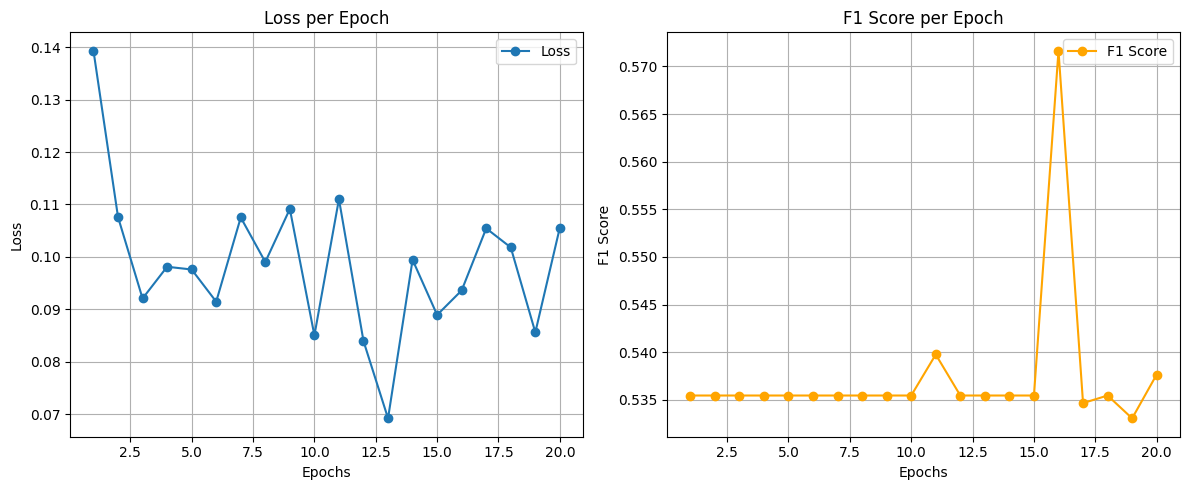

In [ ]:
# визуализация потерь и F1-меры
plt.figure(figsize=(12, 5))

# график потерь
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# график F1-меры
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), f1_values, marker='o', color='orange', label='F1 Score')
plt.title('F1 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

Epoch 20/20

Loss: 0.1056

Acc: 0.9726

F1: 0.5377

Отказано... Кажется, что он опять предсказывает только одну птичку. На 16 эпохе было повышение

Loss: 0.0936

Acc: 0.9736

F1: 0.5717


# **Попытка №5**

In [ ]:
torch.manual_seed(42)

In [ ]:
# все тоже самое
class BirdDataset3(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        image = Image.open(image_path).convert('RGB')

        if label == 1 and self.transform:
            image = self.transform(image)
        else:
            image = transforms.Resize((image_size, image_size))(image)
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, label

In [ ]:
# Аугментация
image_size = 128 # установлю размер изображения 128
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = BirdDataset3(df=train_df, transform=transform)
valid_dataset = BirdDataset3(df=valid_df, transform=transform)  # без аугментации для валидации
test_dataset = BirdDataset3(df=test_df)    # без аугментации для тестирования

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False) # уменьшила батчи до 16 вместо 32
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
class ConvNetMNIST5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(32 * 30 * 30, 128)
        self.fc_2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(p=0.5)

        # Заменила ReLU на ELU
        self.elu = nn.ELU()

    def forward(self, x):
        pred = self.conv_1(x)
        pred = self.elu(pred)
        pred = self.pool(pred)

        pred = self.conv_2(pred)
        pred = self.elu(pred)
        pred = self.pool(pred)

        pred = self.flatten(pred)
        pred = self.fc_1(pred)
        pred = self.elu(pred)

        #  Dropout перед вторым полносвязным слоем
        pred = self.dropout(pred)

        pred = self.fc_2(pred)

        # Softmax для получения вероятностей классов
        return nn.Softmax(dim=1)(pred)

In [ ]:
class_counts = {0: 1196, 1: 814}
total_count = sum(class_counts.values())
weights = {cls: total_count / count for cls, count in class_counts.items()}
#weights_tensor = torch.FloatTensor([weights[0], weights[1]]).cuda()
weights_tensor = torch.FloatTensor([weights[0], weights[1]])
model5 = ConvNetMNIST5().to(device)
optimizer = optim.SGD(model5.parameters(), lr=0.005, momentum=0.9, weight_decay=0.3, nesterov=True)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)



Еще раз запущу обучение, только добавлю отрисовку и логирование

Epoch 1/20, Loss: 0.5092735976453812, F1 Score: 0.8967032967032967
Correct predictions: {0: 1064, 1: 631}, Total predictions: {0: 1196, 1: 814}
Validation F1 Score: 0.9523809523809524
Validation Correct predictions: {0: 358, 1: 141}, Total predictions: {0: 403, 1: 200}
Epoch 2/20, Loss: 0.47609072403302266, F1 Score: 0.7809523809523808
Correct predictions: {0: 1135, 1: 654}, Total predictions: {0: 1196, 1: 814}
Validation F1 Score: 1.0
Validation Correct predictions: {0: 383, 1: 144}, Total predictions: {0: 403, 1: 200}
Epoch 3/20, Loss: 0.4762152497257505, F1 Score: 0.9066666666666666
Correct predictions: {0: 1130, 1: 660}, Total predictions: {0: 1196, 1: 814}
Validation F1 Score: 1.0
Validation Correct predictions: {0: 385, 1: 143}, Total predictions: {0: 403, 1: 200}
Epoch 4/20, Loss: 0.4778382298019197, F1 Score: 1.0
Correct predictions: {0: 1134, 1: 655}, Total predictions: {0: 1196, 1: 814}
Validation F1 Score: 1.0
Validation Correct predictions: {0: 393, 1: 149}, Total predictio

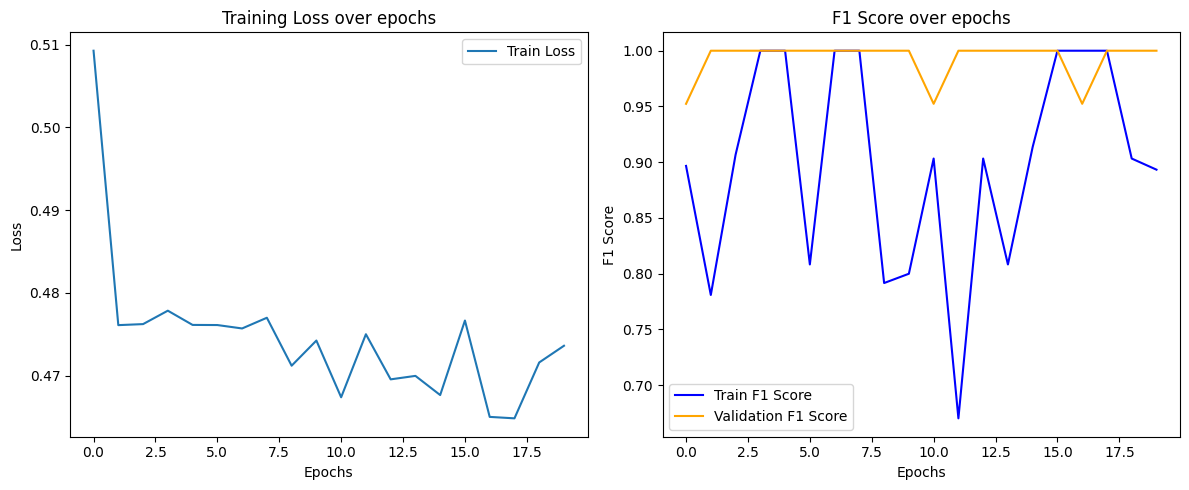

In [ ]:
from sklearn.metrics import f1_score

def train_model(model5, train_loader, valid_loader, criterion, optimizer, num_epochs):
    # списки для хранения значений потерь и F1-метрики
    train_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model5.train()
        running_loss = 0.0
        correct_predictions = {0: 0, 1: 0}  # Предполагаем два класса
        total_predictions = {0: 0, 1: 0}

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model5(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Логирование потерь
            running_loss += loss.item()

            # Получение предсказаний
            _, preds = torch.max(outputs, 1)

            # Подсчет верных предсказаний
            for label in range(2):  # Для каждого класса
                total_predictions[label] += (labels == label).sum().item()
                correct_predictions[label] += ((preds == label) & (labels == label)).sum().item()

        # Вычисление и логирование F1-меры на обучающем наборе
        train_f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
        train_losses.append(running_loss / len(train_loader))
        train_f1_scores.append(train_f1)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, F1 Score: {train_f1}')
        print(f'Correct predictions: {correct_predictions}, Total predictions: {total_predictions}')

        # Валидация модели
        model5.eval()
        val_correct_predictions = {0: 0, 1: 0}
        val_total_predictions = {0: 0, 1: 0}

        with torch.no_grad():
            for val_inputs, val_labels in valid_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model5(val_inputs)
                _, val_preds = torch.max(val_outputs, 1)

                for label in range(2):
                    val_total_predictions[label] += (val_labels == label).sum().item()
                    val_correct_predictions[label] += ((val_preds == label) & (val_labels == label)).sum().item()

        val_f1 = f1_score(val_labels.cpu(), val_preds.cpu(), average='weighted')
        val_f1_scores.append(val_f1)

        print(f'Validation F1 Score: {val_f1}')
        print(f'Validation Correct predictions: {val_correct_predictions}, Total predictions: {val_total_predictions}')

    # визуализация результатов
    plt.figure(figsize=(12, 5))

    # график потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # график F1-метрики
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Train F1 Score', color='blue')
    plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
    plt.title('F1 Score over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# запуск функции обучения
train_model(model5, train_loader, valid_loader, criterion, optimizer, num_epochs=20)

Ну ошибка действительно упала, но как так получилось что у меня validation f1 score на 1 эпохе больше, чем на 20 ...

Epoch 20/20:

Loss: 0.4735975421610333,

F1 Score: 0.8933333333333333

Correct predictions: {0: 1132, 1: 650}

Total predictions: {0: 1196, 1: 814}

Validation F1 Score: 1.0

Validation Correct predictions: {0: 396, 1: 147},

Total predictions: {0: 403, 1: 200}

Epoch 1/20:

Loss: 0.5092735976453812,

F1 Score: 0.8967032967032967


Correct predictions: {0: 1064, 1: 631},

Total predictions: {0: 1196, 1: 814}

Validation F1 Score: 0.9523809523809524

Validation Correct predictions: {0: 358, 1: 141},

 Total predictions: {0: 403, 1: 200}